In [69]:
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from puf import single_bit_flip_test, int2bits
from tqdm import tqdm
import pickle

In [70]:
def execute_puf(delay_diff_vec, chl_bits):
    assert len(delay_diff_vec) == len(chl_bits) + 1
    assert delay_diff_vec[-1] == 0 # Assume no constant bias
    chl_sel_vec = np.zeros(len(chl_bits), dtype=bool)
    for i, chl_bit in enumerate(chl_bits[::-1]):
        if i == 0:
            chl_sel_vec[i] = chl_bit
        else:
            chl_sel_vec[i] = chl_bit ^ chl_sel_vec[i - 1]
    chl_sel_vec = (-1) ** chl_sel_vec[::-1]
    return np.sign(np.dot(delay_diff_vec[:-1], chl_sel_vec))

def sample_puf(n_bit, seed):
    np.random.seed(seed)
    delay_diff_vec = np.random.normal(0, 1, n_bit + 1)
    delay_diff_vec[-1] = 0
    return np.array(delay_diff_vec)

def sample_puf_biased(n_bit, seed):
    np.random.seed(seed)
    delay_diff_vec = np.random.normal(0, 1, n_bit + 1)
    delay_diff_vec[-1] = 0
    delay_diff_vec *= np.abs((np.arange(n_bit + 1) - (n_bit - 1) / 2))
    return np.array(delay_diff_vec)

def sample_puf_first_last(n_bit, seed):
    np.random.seed(seed)
    delay_diff_vec = np.random.normal(0, 1, n_bit + 1)
    delay_diff_vec[-1] = 0
    delay_diff_vec[1:-2] = 0
    return np.array(delay_diff_vec)

def enumerate_crps(puf_delay_diff_vec, n_bit):
    chls = [int2bits(i, n_bit) for i in range(2 ** n_bit)]
    crps = [[execute_puf(puf_delay_diff_vec, chl)] for chl in chls]
    return crps

In [78]:
def plot_avg_flipped_prob(flipped_prob_vec):
    fig, ax = plt.subplots(2, 1)
    avg_flipped_prob = np.mean(flipped_prob_vec, axis=0).flatten()
    std_flipped_prob = np.std(flipped_prob_vec, axis=0).flatten()
    ax[0].plot(avg_flipped_prob)
    ax[0].fill_between(np.arange(len(avg_flipped_prob)), avg_flipped_prob - std_flipped_prob, avg_flipped_prob + std_flipped_prob, alpha=0.2)
    ax[0].axhline(y=0.5, color='r', linestyle='--')
    ax[0].set_xlabel('Bit position')
    ax[0].set_ylabel('Average flipping probability')

    dist_to_50 = np.abs(flipped_prob_vec - 0.5)
    avg_dist_to_50 = np.mean(dist_to_50, axis=0).flatten()
    std_dist_to_50 = np.std(dist_to_50, axis=0).flatten()
    ax[1].plot(avg_dist_to_50)
    ax[1].fill_between(np.arange(len(avg_dist_to_50)), avg_dist_to_50 - std_dist_to_50, avg_dist_to_50 + std_dist_to_50, alpha=0.2)
    ax[1].axhline(y=0, color='r', linestyle='--')
    ax[1].set_xlabel('Bit position')
    ax[1].set_ylabel('Average distance to 0.5')
    plt.tight_layout()
    plt.show()

In [72]:
N_INST = 4096
N_BIT = 10
CENTER_CHLS = [i for i in range(2**N_BIT)]

puf_instances = [sample_puf(N_BIT, seed) for seed in range(N_INST)]
crpss = [enumerate_crps(puf_instance, N_BIT) for puf_instance in puf_instances]
flipped_prob = np.array([
    single_bit_flip_test(
        n_chl_bit=N_BIT,
        crps=crps,
        center_chls=CENTER_CHLS,
    )
    for crps in tqdm(crpss)
])
pickle.dump(crpss, open('arbiter_crpss.pkl', 'wb'))

100%|██████████| 4096/4096 [03:34<00:00, 19.13it/s]


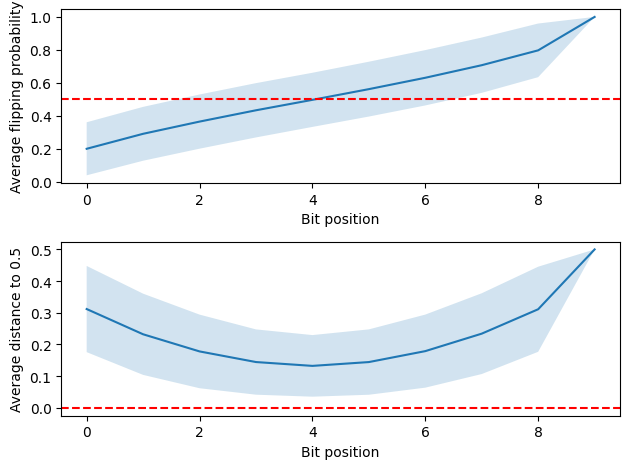

In [79]:
plot_avg_flipped_prob(flipped_prob)

In [74]:

puf_instances = [sample_puf_biased(N_BIT, seed) for seed in range(N_INST)]
crpss = [enumerate_crps(puf_instance, N_BIT) for puf_instance in puf_instances]
flipped_prob_biased = np.array([
    single_bit_flip_test(
        n_chl_bit=N_BIT,
        crps=crps,
        center_chls=CENTER_CHLS,
    )
    for crps in tqdm(crpss)
])

100%|██████████| 4096/4096 [03:33<00:00, 19.16it/s]


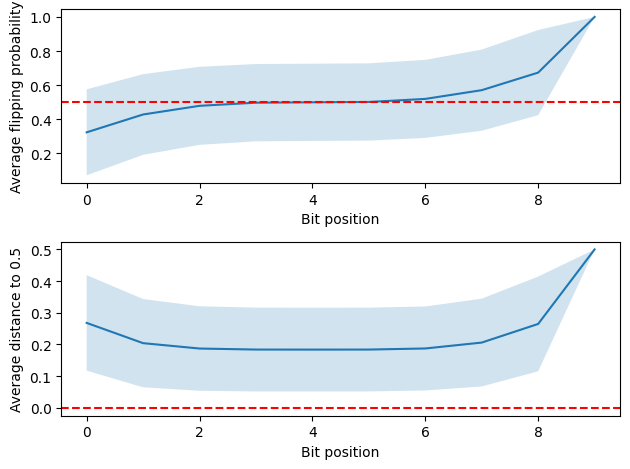

In [80]:
plot_avg_flipped_prob(flipped_prob_biased)

In [76]:

puf_instances = [sample_puf_first_last(N_BIT, seed) for seed in range(N_INST)]
print(puf_instances[0])
crpss = [enumerate_crps(puf_instance, N_BIT) for puf_instance in puf_instances]
flipped_prob_first_last = np.array([
    single_bit_flip_test(
        n_chl_bit=N_BIT,
        crps=crps,
        center_chls=CENTER_CHLS,
    )
    for crps in tqdm(crpss)
])

[1.76405235 0.         0.         0.         0.         0.
 0.         0.         0.         0.4105985  0.        ]


100%|██████████| 4096/4096 [03:33<00:00, 19.14it/s]


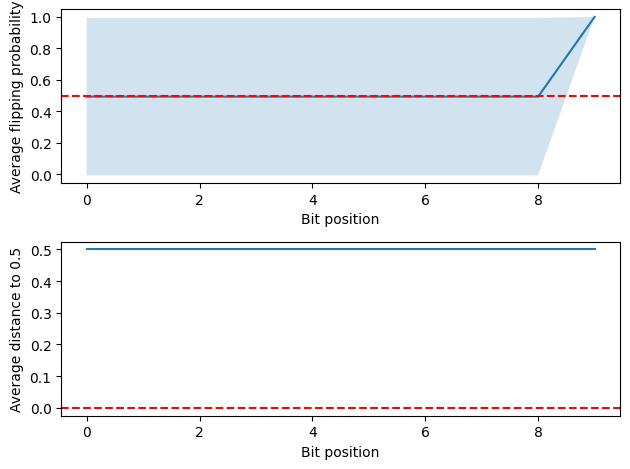

In [81]:
plot_avg_flipped_prob(flipped_prob_first_last)